In [5]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [6]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=64,
    in_channels = 3,
    out_channels = 3,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    
    down_block_types = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels= (64, 128, 160, 224),
    num_class_embeds=2
)


unet.to(device)
unet.eval()

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): Embedding(2, 256)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2

In [7]:
# Count total parameters
total_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 17,642,211


Resolution: 64x64, Peak GPU memory usage: 162.57 MB
Resolution: 128x128, Peak GPU memory usage: 200.68 MB
Resolution: 256x256, Peak GPU memory usage: 369.38 MB
Resolution: 512x512, Peak GPU memory usage: 1044.19 MB


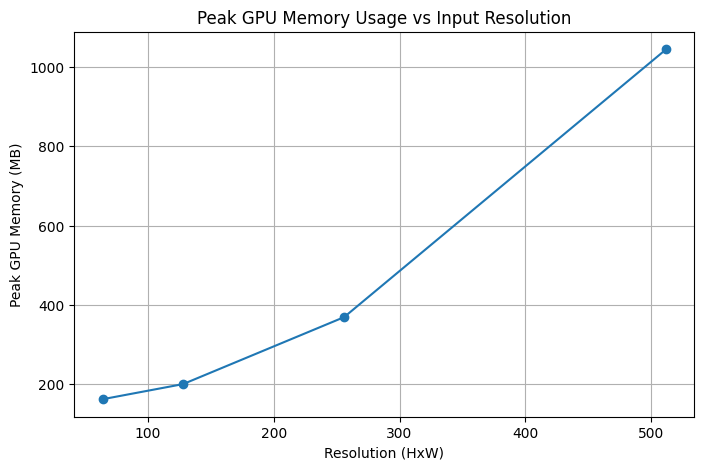

In [8]:
resolutions = [64, 128, 256, 512]  # Different image resolutions to test
peak_memory_MB_list = []

for res in resolutions:
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats(device)
    
    # Generate random input tensor
    x = torch.randn(1, 3, res, res).to(device)
    t = torch.tensor([0]).to(device)
    y = torch.tensor([0]).to(device)
    
    with torch.no_grad():
        output = unet(x, t, y).sample
    
    # Get peak memory usage
    peak_memory_bytes = torch.cuda.max_memory_allocated(device)
    peak_memory_MB = peak_memory_bytes / (1024 ** 2)
    peak_memory_MB_list.append(peak_memory_MB)
    torch.cuda.empty_cache()    
    
    print(f"Resolution: {res}x{res}, Peak GPU memory usage: {peak_memory_MB:.2f} MB")

# Plotting
plt.figure(figsize=(8,5))
plt.plot(resolutions, peak_memory_MB_list, marker='o')
plt.title("Peak GPU Memory Usage vs Input Resolution")
plt.xlabel("Resolution (HxW)")
plt.ylabel("Peak GPU Memory (MB)")
plt.grid(True)
plt.show()

# Using VAE to create latents

In [9]:
from diffusers.models import AutoencoderKL
vae = AutoencoderKL.from_pretrained("sd-legacy/stable-diffusion-v1-5",
                                    subfolder='vae')
vae.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [10]:
from datasets import load_dataset

ds = load_dataset("ashraq/tmdb-celeb-10k",split='train')


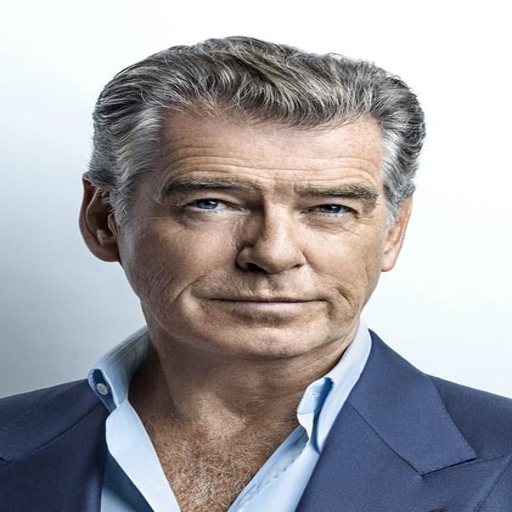

In [12]:
ds[67]['image'].resize((512,512))

In [13]:
from torchvision import transforms
from PIL import Image

images = ds[0:5]['image']

transform = transforms.Compose([ transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
])

images = [transform(image) for image in images]

images = torch.stack(images).to(device)

images.shape

torch.Size([5, 3, 512, 512])

In [14]:
# print meand and std of images
print(torch.min(images),torch.max(images))

with torch.no_grad():
    latent = vae.encode(images).latent_dist.sample()# bs, 4, 64, 64

print(latent.shape)

print(torch.min(latent),torch.max(latent))

tensor(-1., device='cuda:0') tensor(1., device='cuda:0')
torch.Size([5, 4, 64, 64])
tensor(-57.3539, device='cuda:0') tensor(39.3775, device='cuda:0')


In [17]:
latent[0].shape

torch.Size([4, 64, 64])

torch.Size([5, 4, 64, 64])
tensor(-10.4470, device='cuda:0') tensor(7.1726, device='cuda:0')


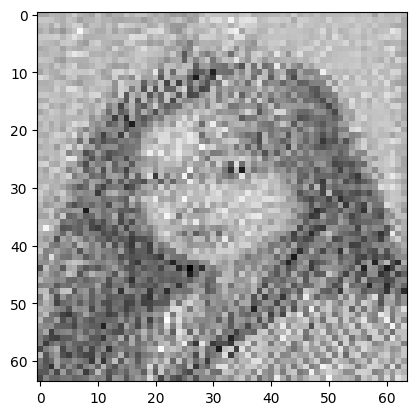

In [18]:
with torch.no_grad():
    latent = vae.encode(images).latent_dist.sample() * vae.config.scaling_factor
    print(latent.shape)

print(torch.min(latent),torch.max(latent))

plt.imshow(torch.mean(latent[0],dim=(0)).cpu(),cmap='grey')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028455496..0.84659636].


tensor(-1.1183, device='cuda:0') tensor(1.0902, device='cuda:0')


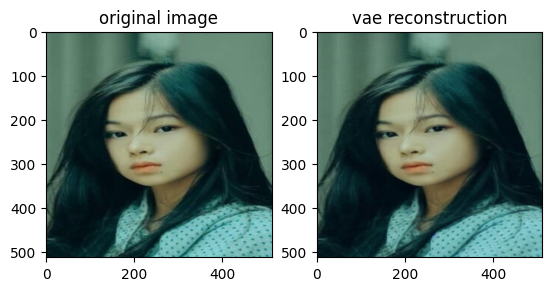

In [19]:
with torch.no_grad():
    recon_images = vae.decode(latent / vae.config.scaling_factor).sample

print(torch.min(recon_images),torch.max(recon_images))

plt.subplot(1,2,1)
plt.imshow(images[0].cpu().permute(1,2,0)*0.5+0.5)
plt.title('original image')
plt.subplot(1,2,2)
plt.title('vae reconstruction')
plt.imshow(recon_images[0].cpu().permute(1,2,0)*0.5+0.5)
plt.show()

# The UNET needs modifiation to have total 4 channels

In [2]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=64,
    in_channels = 4,
    out_channels = 4,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    
    down_block_types = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels= (64, 128, 160, 224),
    num_class_embeds=2
)

unet.eval()
unet.to(device)

UNet2DModel(
  (conv_in): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): Embedding(2, 256)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2

In [3]:
# Reset peak memory stats
torch.cuda.reset_peak_memory_stats(device)

x = torch.randn(1, 4, 64,64).to(device)
t = torch.tensor([0]).to(device)
y = torch.tensor([0]).to(device)

with torch.no_grad():
    output = unet(x,t,y).sample
    print(output.shape)
    
# Print peak memory utilization
peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
print(f"Peak GPU memory usage: {peak_memory_MB:.2f} MB")

torch.Size([1, 4, 64, 64])
Peak GPU memory usage: 94.57 MB
